# Regularización de la regresión lineal

La regularización de los modelos lineales es una técnica que limita los valores de los coeficientes de la regresión, haciendo que tiendan a cero. Con ello se mejora la precisión del modelo y se reduce la varianza de los coeficientes, disminuyendo el riesto de *sobreajuste*. Las técnicas de regularización más frecuentes son la regresión *ridge* y la regresión *lasso*.

Os dejamos una breve explicación de la mátemática que subyace a los procedimientos de regularización. En la regresión lineal por mínimos cuadrados (la técnica sin regularizar) se busca minimizar la suma de cuadrados de los residuos (*residual sum of squares*, RSS):

$ RSS = \displaystyle \sum^{n}_{i=1} (y_i - \beta_0 - \sum^{p}_{j=1} \beta_j x_{ij})^2 $

En la regresión regularizada se añade un término al valor a minimizar. En la regresión *ridge* se minimiza

$ RSS + \lambda \displaystyle \sum^{p}_{j=1} \beta_j^2 $

Y en la *lasso* se minimiza

$ RSS + \lambda \displaystyle \sum^{p}_{j=1} |\beta_j| $

El parámetro $\lambda$ es un valor que se elige arbitrariamente y determina la *fuerza* del efecto de regularización. Lo habitual es repetir el ajuste *ridge* o *lasso* usando distintos valores de $\lambda$ para ver cómo se ven afectados los coeficientes del modelo. Aquellos tiendan a cero mas rápidamente serán los que deberemos eliminar de los modelos porque tendrán un menor poder predictivo. Para mayor información se puede visitar este [link](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/).

Veremos un ejemplo de regularización. Comenzamos cargando como siempre las librerías que necesitaremos:

In [91]:
# Load python packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

# packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm
import statsmodels.formula.api as sm2

# packages for regularization
from sklearn.linear_model import Lasso
from math import pow, sqrt

np.random.seed(1234)

Importamos los datos desde el repositorio y lo cargamos en el espacio de trabajo de Colab:

In [92]:
!wget -P ./../data/ https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_IV/loans.csv

--2023-11-03 06:06:24--  https://raw.githubusercontent.com/pbonillor/DATA_SCIENCE_CON_PYTHON/main/MODULO_IV/loans.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4945425 (4.7M) [text/plain]
Saving to: ‘./../data/loans.csv’

loans.csv           100%[===================>]   4.72M  --.-KB/s    in 0.07s   

2023-11-03 06:06:24 (69.5 MB/s) - ‘./../data/loans.csv’ saved [4945425/4945425]



In [93]:
df = pd.read_csv('../data/loans.csv')

Echamos un vistazo a las variables que tenemos en el dataset. Se trata de datos sobre micro-préstamos concedidos en Africa usando crowdfunding. Para más información sobre las variables puede consultarse este [link](https://www.kaggle.com/aks709/enhanced-analysis-for-kiva-crowdfunding).

In [94]:
df.dtypes

id_number                 int64
loan_amount               int64
lender_count              int64
status                   object
funded_date              object
funded_amount             int64
repayment_term            int64
location_country_code    object
sector                   object
description              object
use                      object
dtype: object

Tenemos dos variables categóricas que vamos a recodificar usando *one-hot-encoding* para poder usarlas en el modelo de regresión:

In [95]:
# create indicator variables for country
for country in df['location_country_code'].unique():
    if country is not np.nan:
        df['country_'+country] = np.where(df.location_country_code == country, 1, 0)

In [96]:
# create indicator variables for sector
for sect in df['sector'].unique():
    df['sector_'+sect] = np.where(df.sector == sect, 1, 0)

In [97]:
df.dtypes

id_number                 int64
loan_amount               int64
lender_count              int64
status                   object
funded_date              object
funded_amount             int64
repayment_term            int64
location_country_code    object
sector                   object
description              object
use                      object
country_BJ                int64
country_BW                int64
country_BF                int64
country_BI                int64
country_CM                int64
country_CG                int64
country_CD                int64
country_EG                int64
country_GH                int64
country_CI                int64
country_KE                int64
country_LS                int64
country_LR                int64
country_MG                int64
country_MW                int64
country_ML                int64
country_MR                int64
country_MZ                int64
country_NG                int64
country_RW                int64
country_

El objetivo del ejercicio es intentar predecir la cantidad a prestar (*loan_amount*) en función de algunos parámetros que a priori nos resultan interesantes: *lender_count*, *sector_Education*, *sector_Clothing*, *sector_Personal Use*, *sector_Retail*, *sector_Transportation*, y *sector_Agriculture*. Comenzamos haciendo una regresión lineal ordinaria sin regularización:

In [98]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define the dependent variable
y = df['loan_amount']
# Define the independent variables
X = df[['lender_count', 'sector_Education', 'sector_Clothing',
        'sector_Personal Use', 'sector_Retail', 'sector_Transportation', 'sector_Agriculture']]
# Add an intercept term to the independent variables
X['cnst'] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     3031.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        06:06:24   Log-Likelihood:                -40379.
No. Observations:                4815   AIC:                         8.077e+04
Df Residuals:                    4807   BIC:                         8.083e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
lender_count             31.11

Ahora repetimos el proceso usando regresión regularizada *lasso* con distintos valores de $\alpha$ oscilando entre 0.001 y 0.999:

In [99]:
alphas = np.arange(0.001, 0.502, 0.002)
lasso_coefs = []
X_train_lasso= X_train[X_train.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True)
    lassoreg.fit(X_train_lasso, y_train)
    lasso_coefs.append(lassoreg.coef_)

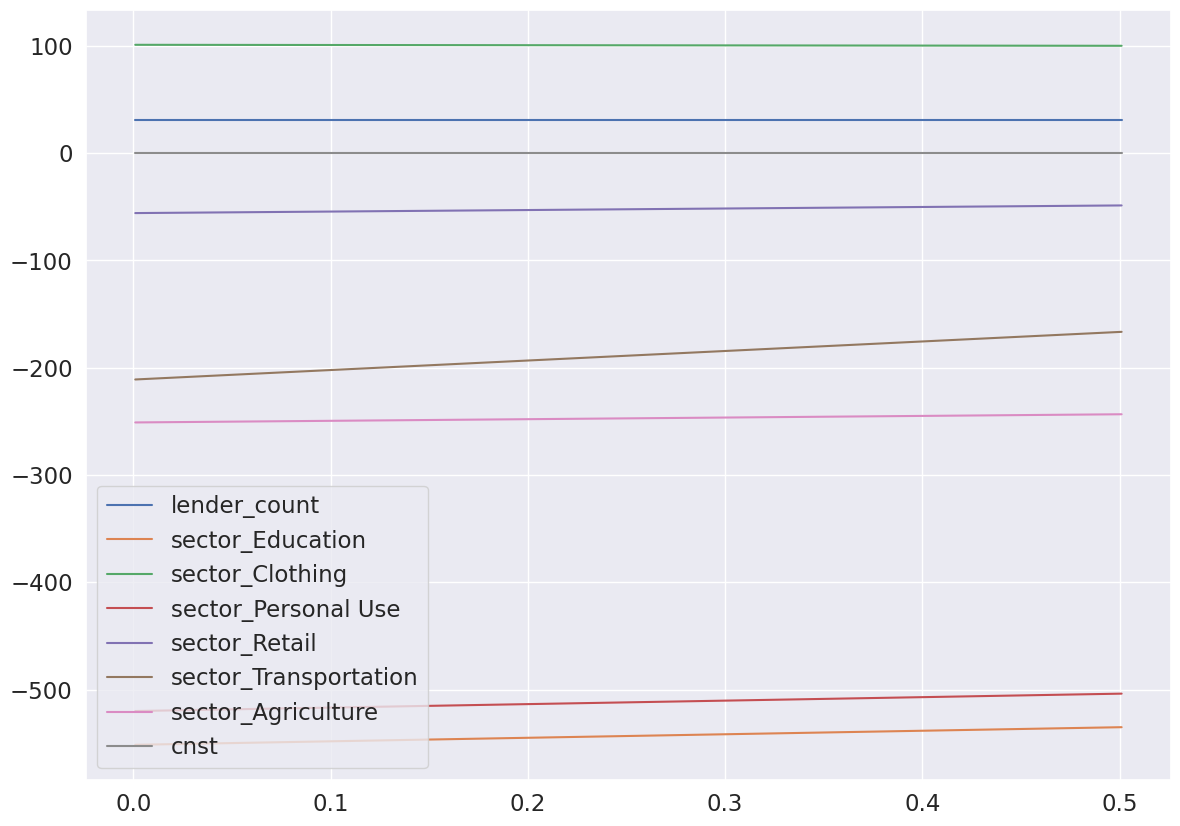

In [100]:
lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_train_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

Vemos que *Retail* y *Transportation* tienden a 0 para valores de $\alpha$ mayores de 0.3. Vamos a eliminar estas variables del modelo de regresión lineal ordinaria:

In [101]:
pd.options.mode.chained_assignment = None  # default='warn'

# Define the dependent variable
y = df['loan_amount']
# Define the independent variables
X = df[['lender_count', 'sector_Education', 'sector_Clothing',
        'sector_Personal Use', 'sector_Agriculture']]
# Add an intercept term to the independent variables
X['cnst'] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     4241.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        06:06:26   Log-Likelihood:                -40381.
No. Observations:                4815   AIC:                         8.077e+04
Df Residuals:                    4809   BIC:                         8.081e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
lender_count           31.1189    

Aunque hemos eliminado dos parámetros el valor de $R^2$ sigue siendo el mismo, lo que indica que las variables eliminadas no aportaban ninguna información a la predicción. Este es un buen ejemplo de cómo usar la regularización como herramienta de selección de características (*feature selection*).

# Algunos detalles importantes sobre la regularización

Hay que tener en cuenta que en la regresión lineal los coeficientes son insensibles a la escala: si se multiplica el valor de una variable por una constante $c$, el valor del coeficiente correspondiente en un modelo de regresión lineal se multiplicaría por un factor $1/c$, el resto de parámetros de calidad del modelo permanecerían iguales. Ilustraremos esto con un ejemplo usando un dataset con tres variables: la caja que hace un restaurante determinado en un día, la distancia en metros del restaurante a la universidad mas cercana, y la distancia en kilómetros al hospital mas cercano. Los datos serán inventados, sacados de una distribución normal.

In [102]:
np.random.seed(1234)

earnings = np.random.normal(2000, 300, 50)
university_distances = np.random.normal(7000,2000,50)
hospital_distances = np.random.normal(7,2,50)

earnings = [a if a > 0 else -a for a in earnings]
university_distances = [a if a > 0 else -a for a in university_distances]
hospital_distances = [a if a > 0 else -a for a in hospital_distances]

In [103]:
df = pd.DataFrame({"earnings": sorted(earnings), "university": sorted(university_distances, reverse=True),
                   'hospital' : sorted(hospital_distances, reverse=True)})

In [104]:
df.head(10)

,earnings,university,hospital
0,1327.194514,11061.207242,11.731537
1,1377.506720,11015.685902,10.860494
2,1393.623554,10091.317609,10.787069
3,1454.891832,9783.972387,9.726963
4,1535.928334,9642.211231,9.449149
5,1642.707292,9067.601465,9.420767
6,1730.852965,8969.839684,9.353625
7,1783.823380,8682.017590,8.968376
8,1803.209197,8633.187853,8.750951
9,1809.042949,8534.737472,8.632254


Representamos la relación entre la caja (*earnings*) y la distancia a la universidad y al hospital más cercanos:

Text(0.5, 1.0, 'Scatter plot of distance to nearest university (in meters) vs earnings')

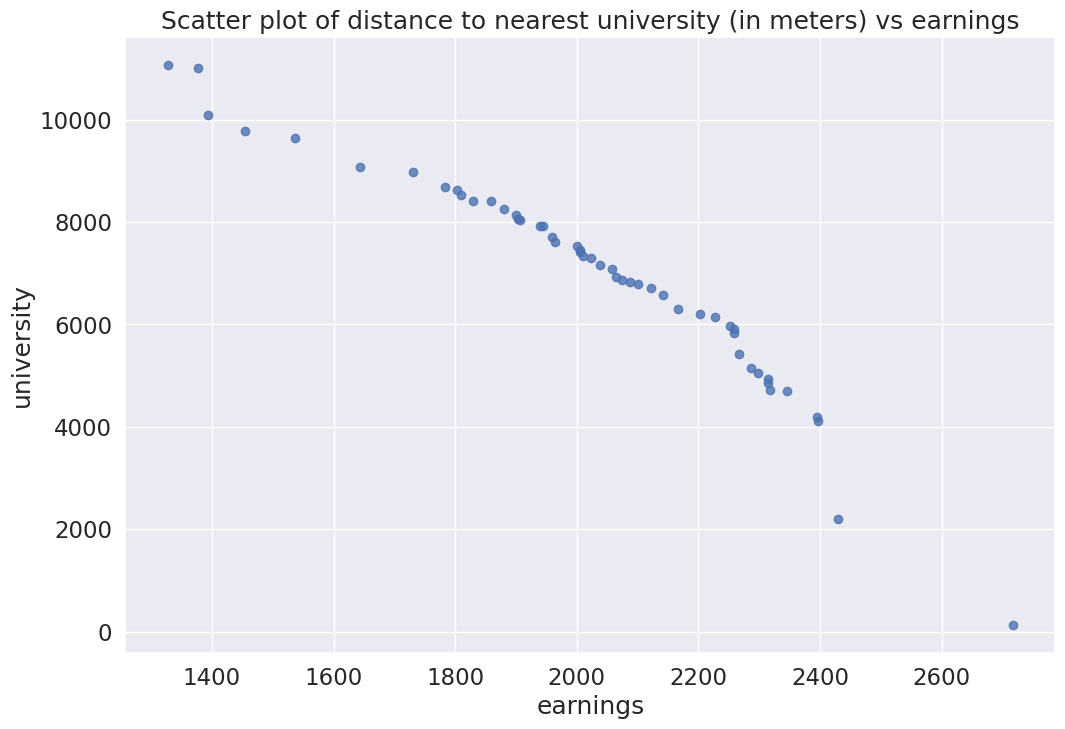

In [105]:
# plot distance to nearest university (in meters) vs. earnings
ax = sns.regplot(x='earnings', y='university', data=df, fit_reg=False)
ax.set_title('Scatter plot of distance to nearest university (in meters) vs earnings')

Text(0.5, 1.0, 'Scatter plot of distance to nearest hospital (in kilometers) vs earnings')

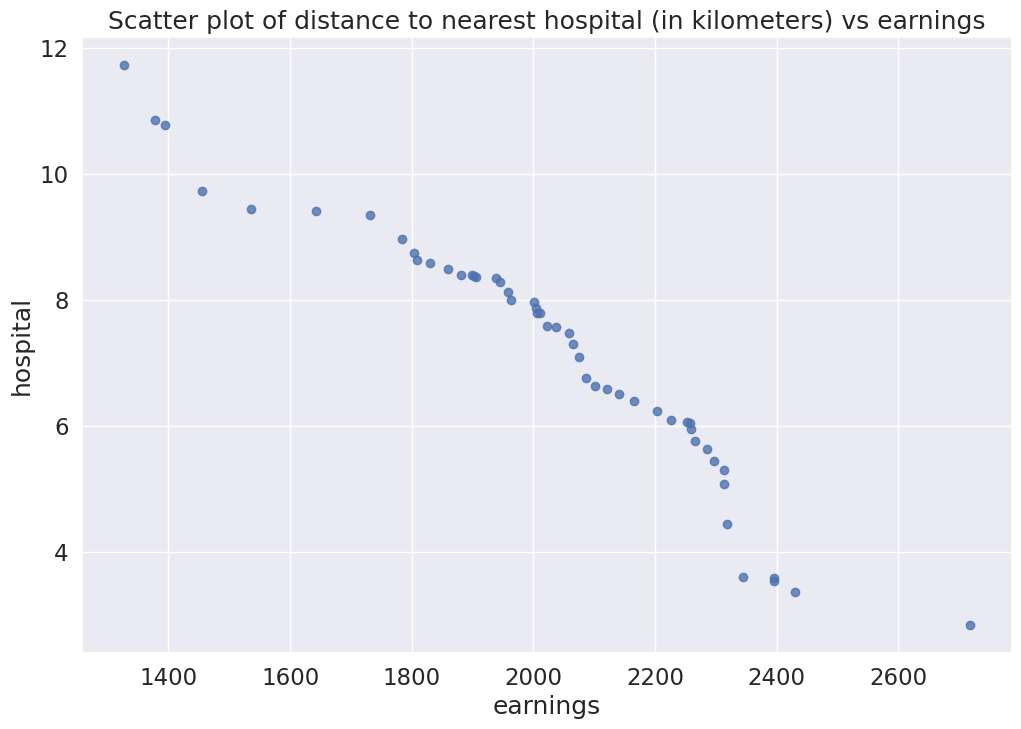

In [106]:
# plot distance to nearest hospital (in kilometers) vs. earnings
ax = sns.regplot(x='earnings', y='hospital', data=df, fit_reg=False)
ax.set_title('Scatter plot of distance to nearest hospital (in kilometers) vs earnings')

Ahora crearemos dos modelo de regresión lineal multivariante: uno sin escalar las variables (dejando una distancia en metros y otra en kilómetros). y otro en el que ambas distancias estén en kilómetros:

In [107]:
model1 = sm2.ols(formula = 'earnings ~ university + hospital', data = df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     353.0
Date:                Fri, 03 Nov 2023   Prob (F-statistic):           4.90e-29
Time:                        06:06:27   Log-Likelihood:                -284.91
No. Observations:                  50   AIC:                             575.8
Df Residuals:                      47   BIC:                             581.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3024.1009     40.095     75.423      0.0

In [108]:
df_scaled = df.copy()
df_scaled['university'] = df_scaled['university']/1000

df_scaled.head(10)

,earnings,university,hospital
0,1327.194514,11.061207,11.731537
1,1377.506720,11.015686,10.860494
2,1393.623554,10.091318,10.787069
3,1454.891832,9.783972,9.726963
4,1535.928334,9.642211,9.449149
5,1642.707292,9.067601,9.420767
6,1730.852965,8.969840,9.353625
7,1783.823380,8.682018,8.968376
8,1803.209197,8.633188,8.750951
9,1809.042949,8.534737,8.632254


In [109]:
model2 = sm2.ols(formula = 'earnings ~ university + hospital', data = df_scaled).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     353.0
Date:                Fri, 03 Nov 2023   Prob (F-statistic):           4.90e-29
Time:                        06:06:27   Log-Likelihood:                -284.91
No. Observations:                  50   AIC:                             575.8
Df Residuals:                      47   BIC:                             581.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3024.1009     40.095     75.423      0.0

Vemos que en ambos casos el valor de $R^2$ es 0.938 y el de $R^2$ ajustada es de 0.935. Los coeficientes para la ordenada en el origen, la universidad y el hospital del primer modelo (sin escalar) son 3024.1009, -0.0643, y -76.3083, y para el segundo modelo (escalado a kilómetros) son 3024.1009, -64.3473, y -76.3083, tal y como esperábamos. El resto de parámetros estadísticos del modelo, como los p-valores, no cambian. Vamos a ver qué ocurre si en lugar de regresión lineal ordinaria usamos regresión regularizada *lasso*.

### Regresión *lasso* con datos sin escalar

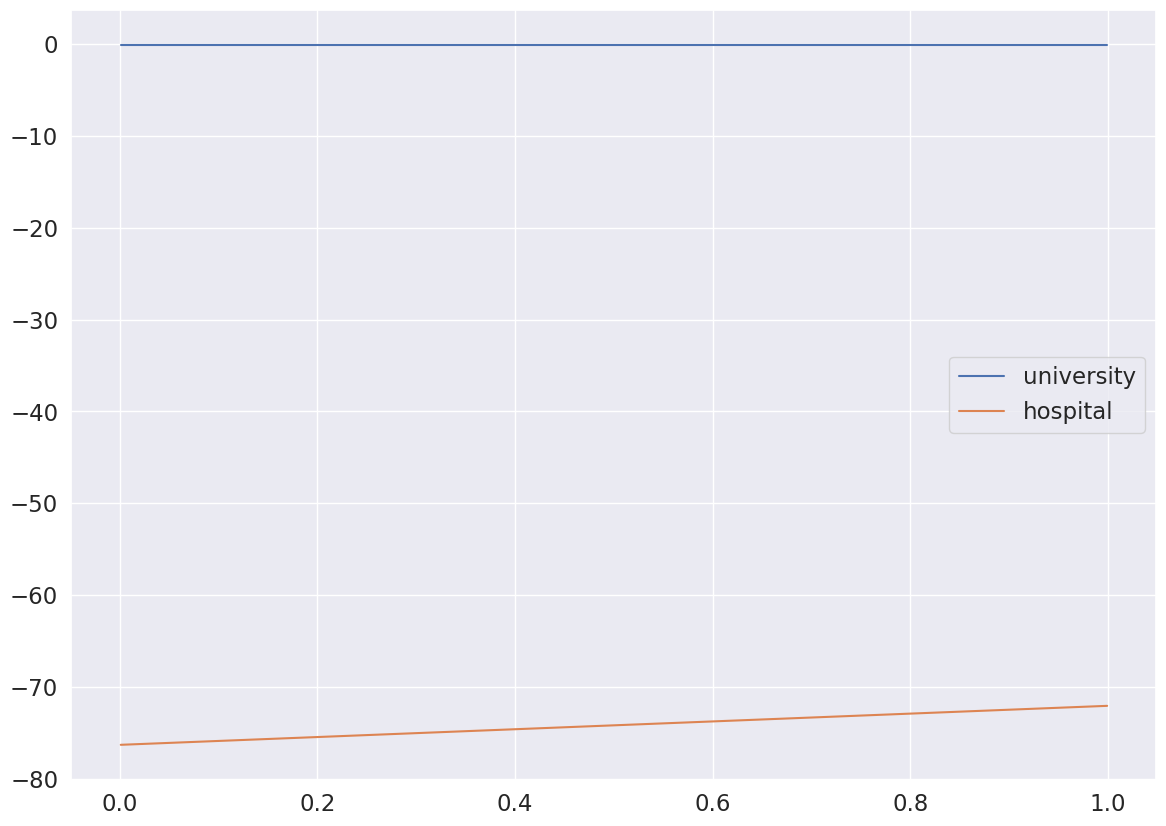

In [110]:
X = df[['university', 'hospital']]
y = df['earnings']

alphas = np.arange(0.001, 1, 0.002)
lasso_coefs = []
X_lasso= X[X.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True)
    lassoreg.fit(X_lasso, y)
    lasso_coefs.append(lassoreg.coef_)

lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

Vemos en el gráfico que los coeficientes para la universidad y el hospital son aproximadamente 0 y -75.

### Regresión *lasso* con datos escalados a kilómetros

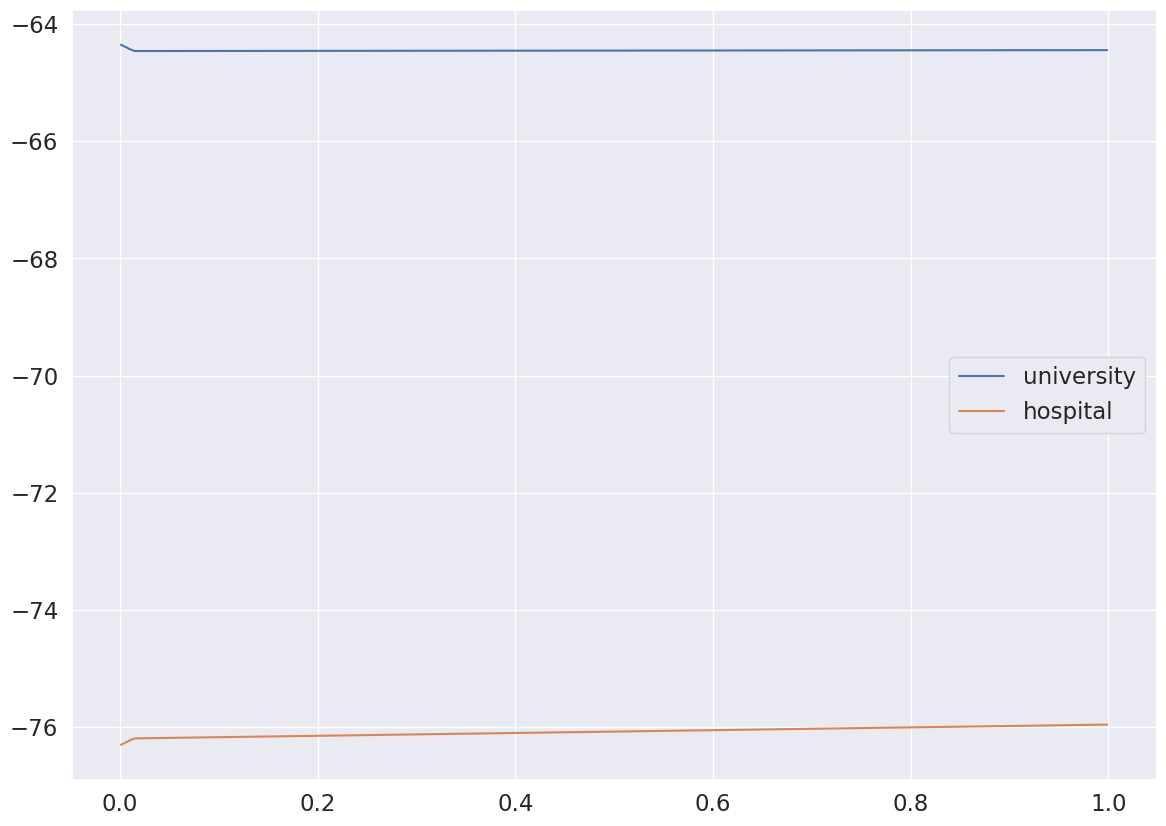

In [111]:
X = df_scaled[['university', 'hospital']]
y = df_scaled['earnings']

alphas = np.arange(0.001, 1, 0.002)
lasso_coefs = []
X_lasso= X[X.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True)
    lassoreg.fit(X_lasso, y)
    lasso_coefs.append(lassoreg.coef_)

lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

Vemos que ahora los coeficientes para universidad y hospital son -64 and -76, respectivamente.

Hemos comprobado que, efectivamente, el escalado sí que afecta al resultado de la regresión *lasso*. Por ello, al usar técnicas de regularización es conveniente *estandarizar* los predictores, lo que puede hacerse empleando la siguiente fórmula:

$ \tilde{x}_{ij} = \frac{x_{ij}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_{ij} - \bar{x}_{j})^2}} $

Vamos a repetir el ejercicio usando los datos sin escalar y estandarizándolos:

In [112]:
df_standardized = df.copy()

In [113]:
university_mean = df_standardized['university'].mean()
university_denom = sqrt(sum((df_standardized['university']-university_mean)**2)/len(df_standardized['university']))

hospital_mean = df_standardized['hospital'].mean()
hospital_denom = sqrt(sum((df_standardized['hospital']-hospital_mean)**2)/len(df_standardized['hospital']))

In [114]:
df_standardized['university'] = df_standardized['university']/university_denom
df_standardized['hospital'] = df_standardized['hospital']/hospital_denom


In [115]:
df_standardized.head()

,earnings,university,hospital
0,1327.194514,5.438299,5.926591
1,1377.506720,5.415918,5.486554
2,1393.623554,4.961448,5.449461
3,1454.891832,4.810340,4.913911
4,1535.928334,4.740642,4.773564


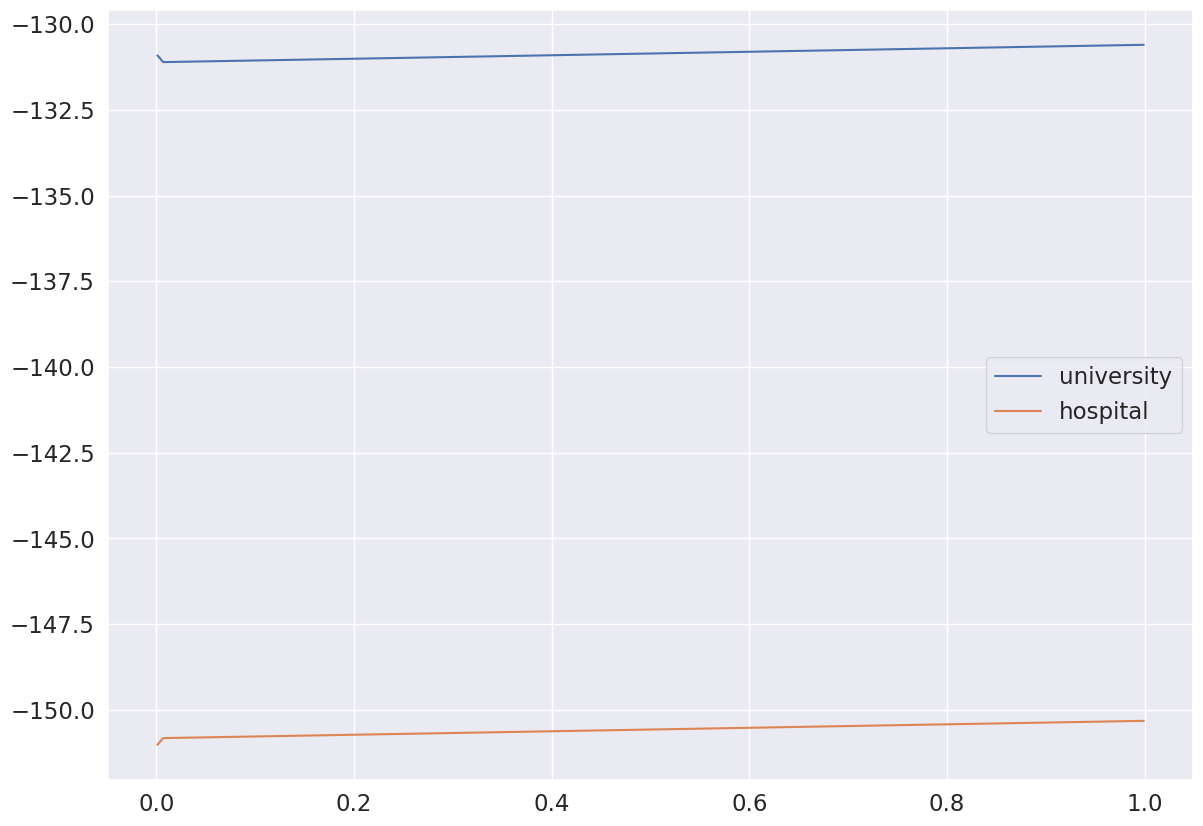

In [116]:
X = df_standardized[['university', 'hospital']]
y = df_standardized['earnings']

alphas = np.arange(0.001, 1, 0.002)
lasso_coefs = []
X_lasso= X[X.columns.tolist()] # Select columns / features for model

for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True)
    lassoreg.fit(X_lasso, y)
    lasso_coefs.append(lassoreg.coef_)

lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

Al estandarizar los predictores los coeficientes tienen ahora el mismo orden de magnitud. Es muy importante tener esto en cuenta antes de sacar conclusiones de un modelo de regresión regularizado.